In [2]:
import numpy as np
import math
from scipy.integrate import quad
import matplotlib.pyplot as plt

import pandas as pd

Algemene constanten:

In [3]:
wg = ["I", "II", "III"]
vb0 = [29.5, 27, 24.5] # [m/s]
K = [0.2, 0.234, 0.281]
n = 0.5

tc = ["0", "II", "III"]
z0 = [0.005, 0.2, 0.5] # [m]
zmin = [1, 4, 7] # [m]
zmax = 200 # [m]
rho = 1.25 # [kg/m3]

Uitgangspunten:

In [4]:
windgebied = "II"
terrein = "II"

B = 110 # [m]
D = 23 # [m]
H = 60 # [m] t.o.v. b.k. maaiveld

gq = 1.5 # veiligheidsfactor wind
cscd = 1 # Eventueel nog uit te breiden, afhankelijk van gebouwtype
n2 = 1.2 # 2e orde factor

In [5]:
wi = wg.index(windgebied)
ti = tc.index(terrein)
cdir = 1
cseason = 1

vb = cdir * cseason * vb0[wi] # [m/s]
#qb = 0.5 * rho * vb**2 * 9.81 # [kN/m2]
#vb

#wi, ti

Beschrijvende functies winddruk over de hoogte:

In [6]:
kr = 0.19 * (z0[ti]/0.05)**0.07
kI = 1
co = 1

def cr(z):
    if z >= zmin[ti]:
        cr = kr * math.log(z / z0[ti])
    else:
        cr = kr * math.log(zmin[ti] / z0[ti])
    return cr

def vm(z):
    return cr(z) * co * vb

def Iv(z):
    if z >= zmin[ti]:
        Iv = kI / (co * math.log(z / z0[ti]))
    else:
        Iv = kI / (co * math.log(zmin[ti] / z0[ti]))
    return Iv

def pp(z):
    return (1 + 7 * Iv(z)) * 0.5 * rho * vm(z)**2 / 10**3 # [kN/m2]

def we(z):
    if (z >= 0 and z <= B) and (B <= H):
        w = pp(B)
    elif (z >= 0 and z <= B) and (B > H):
        w = pp(H)
    elif z > B and z < H-B:
        w = pp(z)
    elif z >= H-B and z <= H:
        w = pp(H)
    else:
        w = pp(z)
    return w

Bepaling vormfactoren:

In [7]:
r  = [0, 0.25, 1, 5, 100]
cpe10_D = [0.7, 0.7, 0.8, 0.8, 0.8]
cpe10_E = [-0.3, -0.3, -0.5, -0.7, -0.7]
f_corr = [0.85, 0.85, 0.85, 1, 1]

cpe10_D = np.interp(H/D, r, cpe10_D)
cpe10_E = np.interp(H/D, r, cpe10_E)
f_corr = np.interp(H/D, r, f_corr)
cwr = 0.04

H/D, cpe10_D, cpe10_E, f_corr

(2.608695652173913, 0.8, -0.5804347826086956, 0.9103260869565217)

Berekening snedekrachten over de hoogte:

In [8]:
if D > min(2*B, 2*H):
    Lwr = D - min(2*B, 2*H)
else:
    Lwr = 0

def qk(z):        
    return f_corr * B * (cpe10_D - cpe10_E) * we(z) + 2 * Lwr * cwr * we(z)

def qki(z):
    return qk(H - z)

def Fk(z):
    return B * Lwr * cwr * we(z)

# Quad integratie functie werkt sinds een tijdje (sinds versie 3.7 van Python?) niet meer lekker 
# op verschillende q-lasten, waarschijnlijk doordat q een gebroken functiedefinitie kent.
# Dit is voor nu opgelost door de windbelasting naar puntlasten op de verdiepingen te vertalen, zie verderop.

#def Vk(z):
#    return (quad(qki, 0, H - z)[0] + Fk(H)) * n2 * cscd

#def Vki(z):
#    return Vk(H - z)

#def VEd(z):
#    return Vk(z) * gq

#def Mk(z):
#    return quad(Vki, 0, H-z)[0]

#def MEd(z):
#    return Mk(z) * gq

#### Bepaling lijn-puntlasten voor bijv. FEM rekenmodellen

In [9]:
#Automatiseren verdiepinghoogtes
nh = [2, 2, 7, 1, 5, 1] # aantal lagen met gelijke hoogte
dh = [2.7, 4.25, 3.85, 4.35, 3.1, 4] # repetitieve gebouwlaaghoogte (in dit geval boven de 1e verdieping)

hv = []
for i in range(len(nh)):
    for k in range(nh[i]):
        hv = np.append(hv, dh[i])

#Automatiseren verdiepingsbreedtes
nb = [2, 16]
db = [0, 63]

bv = []
for i in range(len(nb)):
    for k in range(nb[i]):
        bv = np.append(bv, db[i])

h_mv = 5.4 # hoogte m.v. t.o.v. laagste niveau

if len(bv) is not len(hv):
    print("b en h arrays niet even groot; dit is wel noodzakelijk voor een goede werking!")
    print(str(len(bv)) + " / " + str(len(hv)))

hv, bv

(array([2.7 , 2.7 , 4.25, 4.25, 3.85, 3.85, 3.85, 3.85, 3.85, 3.85, 3.85,
        4.35, 3.1 , 3.1 , 3.1 , 3.1 , 3.1 , 4.  ]),
 array([ 0.,  0., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63.,
        63., 63., 63., 63., 63.]))

In [10]:
lvl = []
z_strip = []
h_strip = []
wz = []

for i in range(len(hv)):
    if i == 0:
        niv = 0
        zs = hv[i] - h_mv
    else:
        niv = lvl[i-1] + hv[i-1]
        zs = z_strip[i-1] + hv[i]
    hs = niv + 0.5*hv[i]
    lvl = np.append(lvl, niv)
    z_strip = np.append(z_strip, zs)
    h_strip = np.append(h_strip, hs)
    wz = np.append(wz, we(z_strip[i]))

lvl = np.append(lvl, lvl[i] + hv[i])

qp = []
wn = []

for i in range(len(lvl)):
    qp = np.append(qp, pp(lvl[i] - h_mv))
    wn = np.append(wn, we(lvl[i]))

In [11]:
p_D = np.around(cpe10_D * n2 * wz, 2)
p_E = np.around(cpe10_E * n2 * wz, 2)

F_D = np.around(bv * hv * p_D, 1)
F_E = np.around(bv * hv * p_E, 1)

In [12]:
F_o = []
F_b = []
q_o = []
q_b = []

for i in range(len(lvl)):
    if i == 0:
        Fo = 0
        Fb = 0.5 * (F_D[i] - F_E[i])
        qo = 0
        qb = 0 if (Fb == 0) else Fb / bv[i]
    elif i == len(lvl) - 1:
        Fo = 0.5 * (F_D[i-1] - F_E[i-1])
        Fb = 0
        qo = 0 if (Fo == 0) else Fo / bv[i-1]
        qb = 0
    else:
        Fo = 0.5 * (F_D[i-1] - F_E[i-1])
        Fb = 0.5 * (F_D[i] - F_E[i])
        qo = 0 if (Fo == 0) else Fo / bv[i-1]
        qb = 0 if (Fb == 0) else Fb / bv[i]
    
    F_o = np.append(F_o, Fo)
    F_b = np.append(F_b, Fb)
    q_o = np.append(q_o, qo)
    q_b = np.append(q_b, qb)

F = F_o + F_b
q = q_o + q_b
qDo = cpe10_D / (cpe10_D - cpe10_E) * q_o
qDb = cpe10_D / (cpe10_D - cpe10_E) * q_b
qEo = q_o - qDo
qEb = q_b - qDb

In [13]:
FEd = np.around(gq * f_corr * F, 1)
hv_ = np.append(hv, 0)

from scipy.ndimage.interpolation import shift
VEd = np.around(np.cumsum(FEd[::-1])[::-1], 1)
MEd = np.around(np.cumsum(np.append(VEd[1:], 0)[::-1] * hv_[::-1])[::-1], 1)
# [::-1] keert een array om; dit is nodig om de dwarskracht van boven naar beneden op te tellen
# (en idem voor het cumulatief moment)

In [14]:
qD = np.around(qDo + qDb, 2)
qE = -np.around(qEo + qEb, 2)
q = np.around((qD - qE) * f_corr,2)

df = pd.DataFrame([lvl - h_mv, bv, np.around(wz,2), qD, \
                   qE, q, np.around(VEd,0), np.around(MEd,0)]).T
df.columns = ['$h_{niv}$', '$$b_{wind}^{\ (1)}$$', '$$w_{z}(z_{strip})^{\ (1)}$$', '$$q_{D,max}^{\ (2)}$$', \
              '$$q_{E,max}^{\ (2)}$$', '$$q_{tot}^{\ (3)}$$','$V_{Ed}$', '$M_{Ed}$']

df = df.iloc[::-1]

In [15]:
from IPython.display import Markdown as md

outp = """
$\\begin{align*}
&H & &= \ %.2f \ m & & (t.b.v. \ bepaling \ extreme \ stuwdruk) \\\\
&D & &= \ %.2f \ m & & (t.b.v. \ bepaling \ drukfactoren) \\\\
&c_{pe,D} & &= \ + %.2f \\\\
&c_{pe,E} & &= \ %.2f \\\\
\\\\
&f_{corr,D+E} & &= \ %.2f \\\\
&n/(n-1) & &= \ %.2f \\\\
&g_{q} & &= \ %.2f \\\\
\\end{align*}$
"""%(H, D, cpe10_D, cpe10_E, f_corr, n2, gq)

In [16]:
md(outp)


$\begin{align*}
&H & &= \ 60.00 \ m & & (t.b.v. \ bepaling \ extreme \ stuwdruk) \\
&D & &= \ 23.00 \ m & & (t.b.v. \ bepaling \ drukfactoren) \\
&c_{pe,D} & &= \ + 0.80 \\
&c_{pe,E} & &= \ -0.58 \\
\\
&f_{corr,D+E} & &= \ 0.91 \\
&n/(n-1) & &= \ 1.20 \\
&g_{q} & &= \ 1.50 \\
\end{align*}$


In [17]:
from IPython.display import HTML
HTML(df.to_html(index=False))

$h_{niv}$,$$b_{wind}^{\ (1)}$$,$$w_{z}(z_{strip})^{\ (1)}$$,"$$q_{D,max}^{\ (2)}$$","$$q_{E,max}^{\ (2)}$$",$$q_{tot}^{\ (3)}$$,$V_{Ed}$,$M_{Ed}$
59.30,NaN,NaN,2.78,-2.02,4.37,413.0,0.0
55.30,63.0,1.45,4.94,-3.58,7.76,1146.0,1652.0
52.20,63.0,1.45,4.31,-3.13,6.77,1786.0,5204.0
49.10,63.0,1.45,4.31,-3.13,6.77,2426.0,10740.0
46.00,63.0,1.45,4.31,-3.13,6.77,3066.0,18261.0
42.90,63.0,1.45,4.31,-3.13,6.77,3706.0,27767.0
39.80,63.0,1.45,5.18,-3.76,8.14,4475.0,39256.0
35.45,63.0,1.45,5.70,-4.14,8.96,5322.0,58724.0
31.60,63.0,1.45,5.35,-3.89,8.41,6117.0,79214.0
27.75,63.0,1.45,5.35,-3.89,8.41,6912.0,102763.0


<font size=1>
    <sup>(1)</sup> = waarde <u>boven</u> gegeven niveau; overige waarden zijn <i>ter hoogte van</i> het betreffende niveau
    </br>
    <sup>(2)</sup> = maximale waarde (dus gevel boven & onder het betreffende niveau)
    </br>
    <sup>(3)</sup> = $(q_{D,max} + q_{E,max}) \ \cdot \ f_{corr,D+E}$ (representatief)
</font>
</br></br>

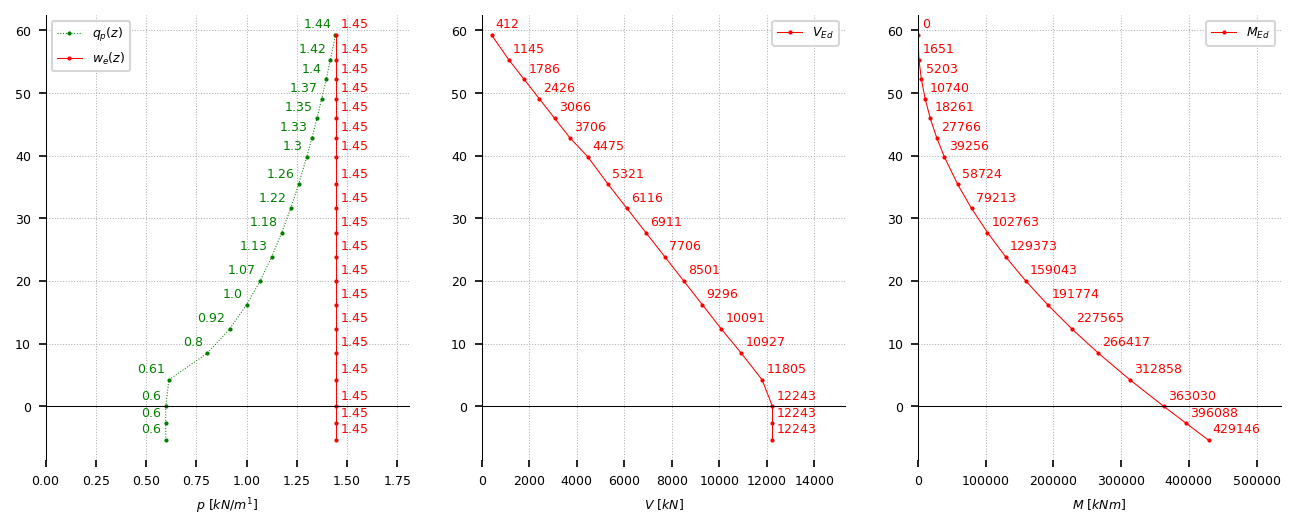

In [18]:
plotsize = (27/2.54,10/2.54) #afmeting in inches
plot_dpi = 150
font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)
fig, ax = plt.subplots(1, 3, figsize=plotsize, dpi=plot_dpi)

z = lvl - h_mv

x = [wn, VEd, MEd]

if B < H:
    ax[0].axhline(y=B, linestyle = ':', color="r", linewidth=0.5)
    ax[0].annotate(xy=[0, B], textcoords="offset points", xytext=(2,2), fontsize=5, color='r', s='z = B')

if H - B > B:
    ax[0].axhline(y=H-B, linestyle = ':', color="r", linewidth=0.5)
    ax[0].annotate(xy=[0, H-B], textcoords="offset points", xytext=(2,2), fontsize=5, color='r', s='z = H-B')

ax[0].plot(qp, z, color='green', marker='o', markersize=1, linewidth=0.5, linestyle='dotted', label='$q_{p}(z)$')
ax[0].plot(wn, z, color='red', marker='o', markersize=1, linewidth=0.5, label='$w_{e}(z)$')
ax[1].plot(VEd, z, color='red', marker='o', markersize=1, linewidth=0.5, label='$V_{Ed}$')
ax[2].plot(MEd, z, color='red', marker='o', markersize=1, linewidth=0.5, label='$M_{Ed}$')

ax[0].set_xlabel('$p \ [kN/m^{1}]$', fontsize=6)
ax[1].set_xlabel('$V \ [kN]$', fontsize=6)
ax[2].set_xlabel('$M \ [kNm]$', fontsize=6)

ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper right')
ax[2].legend(loc = 'upper right')

for i in range(len(z)):
    ax[0].annotate(np.around(qp[i],2), (qp[i], z[i]), textcoords="offset points", xytext=(-2,2), va = 'bottom', ha='right', fontsize=6, color='green')
    ax[0].annotate(np.around(wn[i],2), (wn[i], z[i]), textcoords="offset points", xytext=(2,2), va = 'bottom', ha='left', fontsize=6, color='red')
    ax[1].annotate(np.around(int(VEd[i]),2), (VEd[i], z[i]), textcoords="offset points", xytext=(2,2), va = 'bottom', ha='left', fontsize=6, color='red')
    ax[2].annotate(np.around(int(MEd[i]),2), (MEd[i], z[i]), textcoords="offset points", xytext=(2,2), va = 'bottom', ha='left', fontsize=6, color='red')

for i in range(len(ax)):
    ax[i].set_xlim(0, max(x[i]) * 1.25)
    ax[i].grid(True, which='both', linewidth=0.5, linestyle='dotted')
    for j in ['left','bottom']:
        ax[i].spines[j].set_color('none')
    for j in ['top', 'right']:
        ax[i].spines[j].set_linewidth(0.5)
        ax[i].spines[j].set_position('zero')

plt.show()

#### Test vervormingen

In [19]:
E = 15 # GPa
nu = 0.2
G = E / (2 * (1 + nu))

Iy = 161 + 52 # [m^4]
Av = 6.6 + 4.0

Mk = MEd / gq
Vk = VEd / gq

In [20]:
phi = []
ux = []

for i in range(len(lvl)):
    if i == 0:
        phi_ = 0
        ux_ = 0
    else:
        phi_0 = phi[i-1]
        phi_M = Mk[i] * hv[i-1] / (E * Iy * 10**6)
        phi_F = Vk[i] * hv[i-1]**2 / (2 * E * Iy * 10**6)
        
        ux_0 = ux[i-1]
        ux_phi = phi[i-1] * hv[i-1]
        ux_M_u = Mk[i] * hv[i-1]**2 / (2 * E * Iy * 10**6)
        ux_F_u = Vk[i] * hv[i-1]**3 / (3 * E * Iy * 10**6)
        ux_V_u = Vk[i] * hv[i-1] / (G * Av * 10**6)
        
        phi_ = phi_0 + phi_M + phi_F
        ux_ = ux_0 + ux_phi + ux_M_u + ux_F_u + ux_V_u
    phi = np.append(phi, phi_)
    ux = np.append(ux, ux_)

print(ux * 10**3)

[ 0.          0.65067092  1.90384204  4.95806864  9.15624647 13.80009873
 19.11855921 25.00093117 31.34598311 38.06194872 45.06652708 52.28688247
 60.6255527  66.64393869 72.698698   78.77077065 84.84507559 90.91051073
 98.71288073]
